In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
)
from statannotations.Annotator import Annotator
from ripple_heterogeneity.replay import replay_run, per_cell_contribution
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
from matplotlib.ticker import AutoMinorLocator
import copy
import os
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [2]:
# replay_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay_82622'
replay_save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_02_17_23"
replay_df = replay_run.load_results(replay_save_path,pre_task_post=False)

In [41]:
replay_df.keys()

Index(['start', 'stop', 'duration', 'n_active', 'inactive_bin_prop',
       'trajectory_score', 'weighted_corr', 'r_squared', 'slope', 'intercept',
       'score_pval_time_swap', 'score_pval_col_cycle',
       'weighted_corr_pval_time_swap', 'weighted_corr_pval_col_cycle',
       'score_z_time_swap', 'score_z_col_cycle', 'weighted_corr_z_time_swap',
       'weighted_corr_z_col_cycle', 'traj_dist', 'traj_speed', 'traj_step',
       'replay_type', 'pop_partic', 'decoding_r2', 'decoding_r2_pval',
       'decoding_median_error', 'total_units', 'direction', 'basepath'],
      dtype='object')

In [3]:
basepaths = ['Z:\\Data\\AYAold\\AB3\\AB3_38_41',
                'Z:\\Data\\AYAold\\AYA6\\day17',
                'Z:\\Data\\AYAold\\AYA6\\day19',
                'Z:\\Data\\Can\\OML22\\day19',
                'Z:\\Data\\Can\\OML22\\day8',
                'Z:\\Data\\GirardeauG\\Rat10\\Rat10-20140702',
                'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150310',
                'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150313',
                'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150314',
                'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150315',
                'Z:\\Data\\GrosmarkAD\\Cicero\\Cicero_09102014',
                'Z:\\Data\\HMC1\\day10',
                'Z:\\Data\\HMC1\\day14',
                'Z:\\Data\\HMC1\\day9',
                'Z:\\Data\\Kenji\\ec013.393_418',
                'Z:\\Data\\Kenji\\ec013.677_699',
                'Z:\\Data\\Kenji\\ec013.634_653',
                'Z:\\Data\\Kenji\\ec013.656_674',
                "Z:\Data\GirardeauG\Rat11\Rat11-20150331",
                "Z:\Data\GirardeauG\Rat11\Rat11-20150330",
                "Z:\Data\GirardeauG\Rat10\Rat10-20140629",
                "Z:\Data\GirardeauG\Rat10\Rat10-20140622",
                "Z:\Data\GirardeauG\Rat10\Rat10-20140624",
                "Z:\Data\GirardeauG\Rat11\Rat11-20150327",
                "Z:\Data\GirardeauG\Rat08\Rat08-20130717",
                "Z:\Data\GirardeauG\Rat11\Rat11-20150316",
                "Z:\Data\Kenji\ec016.267_278",
                "Z:\Data\AYAold\AB3\AB3_38_41",
                "Z:\Data\AYAold\AYA9\day17",
                "Z:\Data\GrosmarkAD\Achilles\Achilles_11012013",
                ]

keep_idx = np.in1d(replay_df.basepath, basepaths)
replay_df = replay_df[keep_idx]

In [4]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\per_cell_contribution_v2"
)
batch_analysis.run(
    replay_df,
    save_path,
    per_cell_contribution.run,
    parallel=True,
    verbose=True,
    replay_save_path=replay_save_path,
    n_shuffles_single_cell=1000,
    n_shuffles_corr=1000,
)

results_df = batch_analysis.load_results(save_path)

100%|██████████| 29/29 [00:00<00:00, 199.16it/s]


In [5]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\per_cell_contribution_v2"
)
results_df = batch_analysis.load_results(save_path)


In [6]:
# add animal ids
results_df = functions.add_animal_id(results_df)

# fix unknown deep sups
results_df.deepSuperficial = results_df.deepSuperficial.replace(np.nan, "unknown")

# add n replays
for basepath in results_df.basepath.unique():
    results_df.loc[results_df.basepath == basepath, "n_replays"] = results_df.query(
        "basepath==@basepath"
    ).start.nunique()

results_df["pcc_raw"] = results_df.pcc / results_df.n_active


<AxesSubplot: xlabel='pcc', ylabel='pcc_raw'>

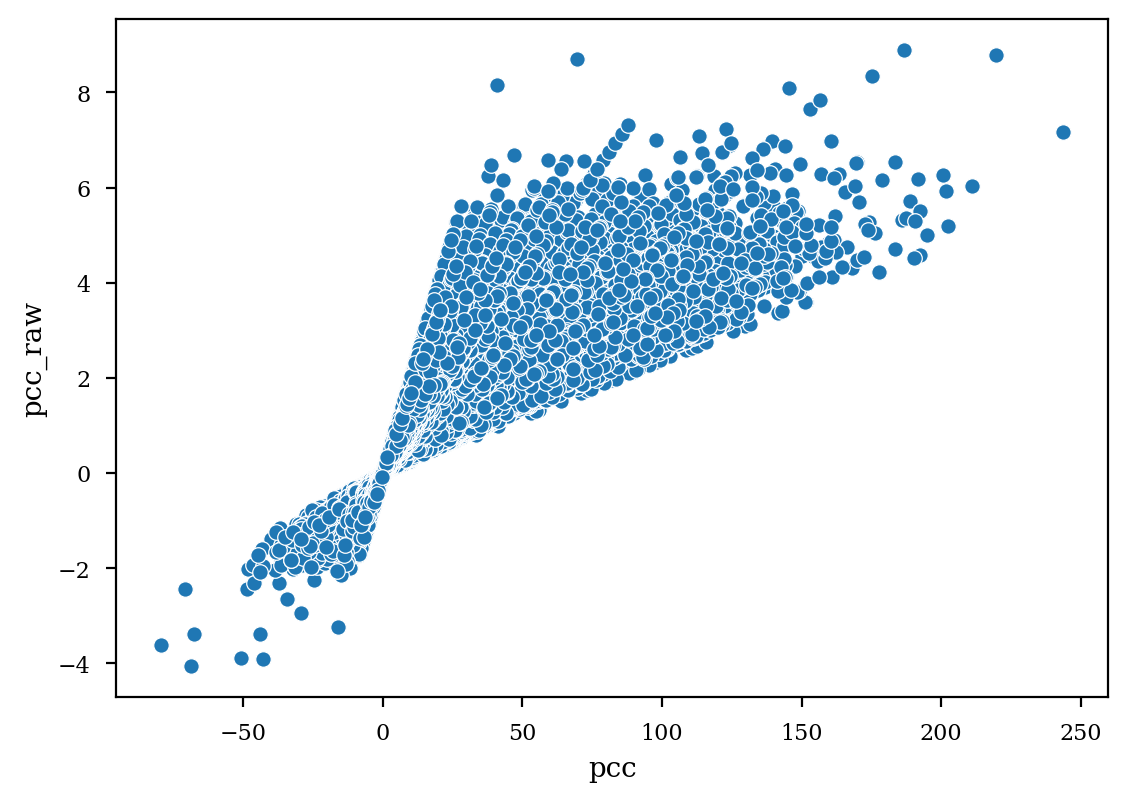

In [7]:
sns.scatterplot(data=results_df,x="pcc",y="pcc_raw")

## add pre task post to results

In [8]:
results_df["session_structure"] = "unknown"
for basepath in results_df.basepath.unique():
    epoch_df = loading.load_epoch(basepath)
    epoch_df = compress_repeated_epochs.main(epoch_df, epoch_name="sleep")
    epoch_df = epoch_df.reset_index()
    pattern_idx, _ = functions.find_epoch_pattern(
        epoch_df.environment, ["sleep", "linear", "sleep"]
    )

    if pattern_idx is None:
        continue

    results_df.loc[
        (results_df.basepath == basepath)
        & (results_df.epoch_n == epoch_df.loc[np.where(pattern_idx)[0]].index[0]),
        "session_structure",
    ] = "pre"
    results_df.loc[
        (results_df.basepath == basepath)
        & (results_df.epoch_n == epoch_df.loc[np.where(pattern_idx)[0]].index[1]),
        "session_structure",
    ] = "task"

    results_df.loc[
        (results_df.basepath == basepath)
        & (results_df.epoch_n == epoch_df.loc[np.where(pattern_idx)[0]].index[2]),
        "session_structure",
    ] = "post"

In [9]:
basepaths = ['Z:\\Data\\AYAold\\AB3\\AB3_38_41',
                'Z:\\Data\\AYAold\\AYA6\\day17',
                'Z:\\Data\\AYAold\\AYA6\\day19',
                'Z:\\Data\\Can\\OML22\\day19',
                'Z:\\Data\\Can\\OML22\\day8',
                'Z:\\Data\\GirardeauG\\Rat10\\Rat10-20140702',
                'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150310',
                'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150313',
                'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150314',
                'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150315',
                'Z:\\Data\\GrosmarkAD\\Cicero\\Cicero_09102014',
                'Z:\\Data\\HMC1\\day10',
                'Z:\\Data\\HMC1\\day14',
                'Z:\\Data\\HMC1\\day9',
                'Z:\\Data\\Kenji\\ec013.393_418',
                'Z:\\Data\\Kenji\\ec013.677_699',
                'Z:\\Data\\Kenji\\ec013.634_653',
                'Z:\\Data\\Kenji\\ec013.656_674',
                "Z:\Data\GirardeauG\Rat11\Rat11-20150331",
                "Z:\Data\GirardeauG\Rat11\Rat11-20150330",
                "Z:\Data\GirardeauG\Rat10\Rat10-20140629",
                "Z:\Data\GirardeauG\Rat10\Rat10-20140622",
                "Z:\Data\GirardeauG\Rat10\Rat10-20140624",
                "Z:\Data\GirardeauG\Rat11\Rat11-20150327",
                "Z:\Data\GirardeauG\Rat08\Rat08-20130717",
                "Z:\Data\GirardeauG\Rat11\Rat11-20150316",
                "Z:\Data\Kenji\ec016.267_278",
                "Z:\Data\AYAold\AB3\AB3_38_41",
                "Z:\Data\AYAold\AYA9\day17",
                "Z:\Data\GrosmarkAD\Achilles\Achilles_11012013",
                ]

keep_idx = np.in1d(results_df.basepath, basepaths)
results_df = results_df[keep_idx]

## plot pcc for pre task post and unknown

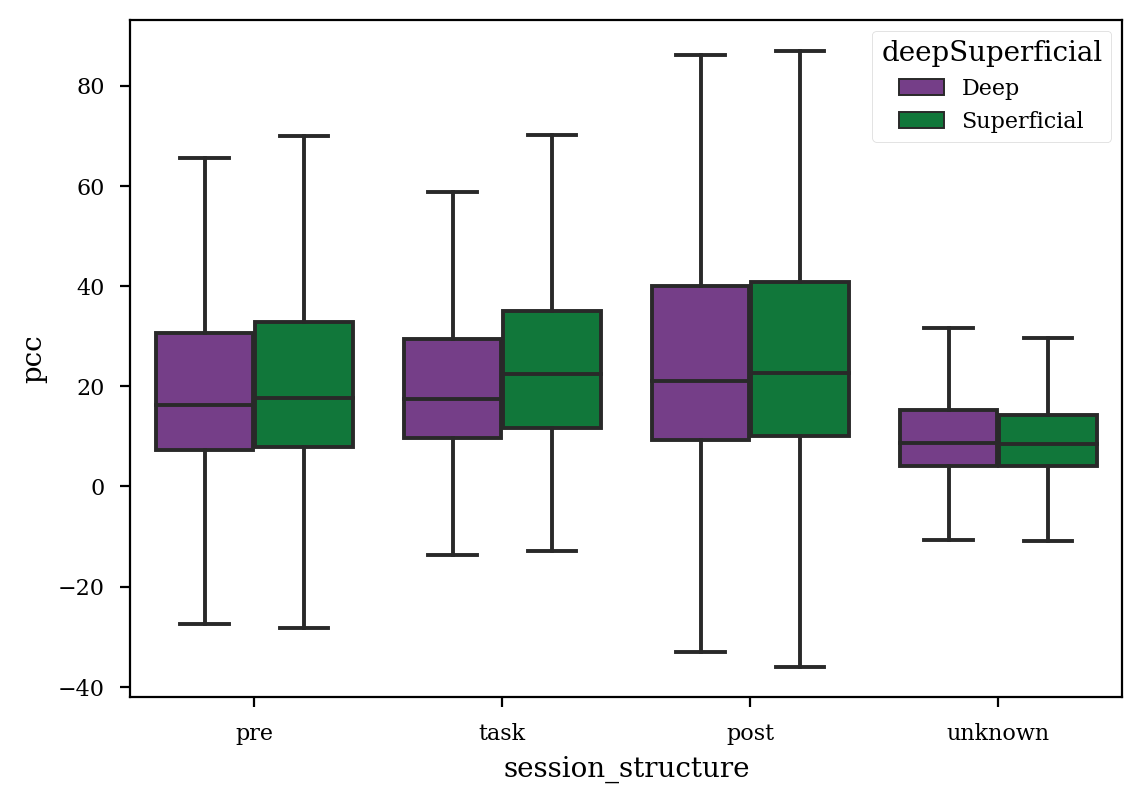

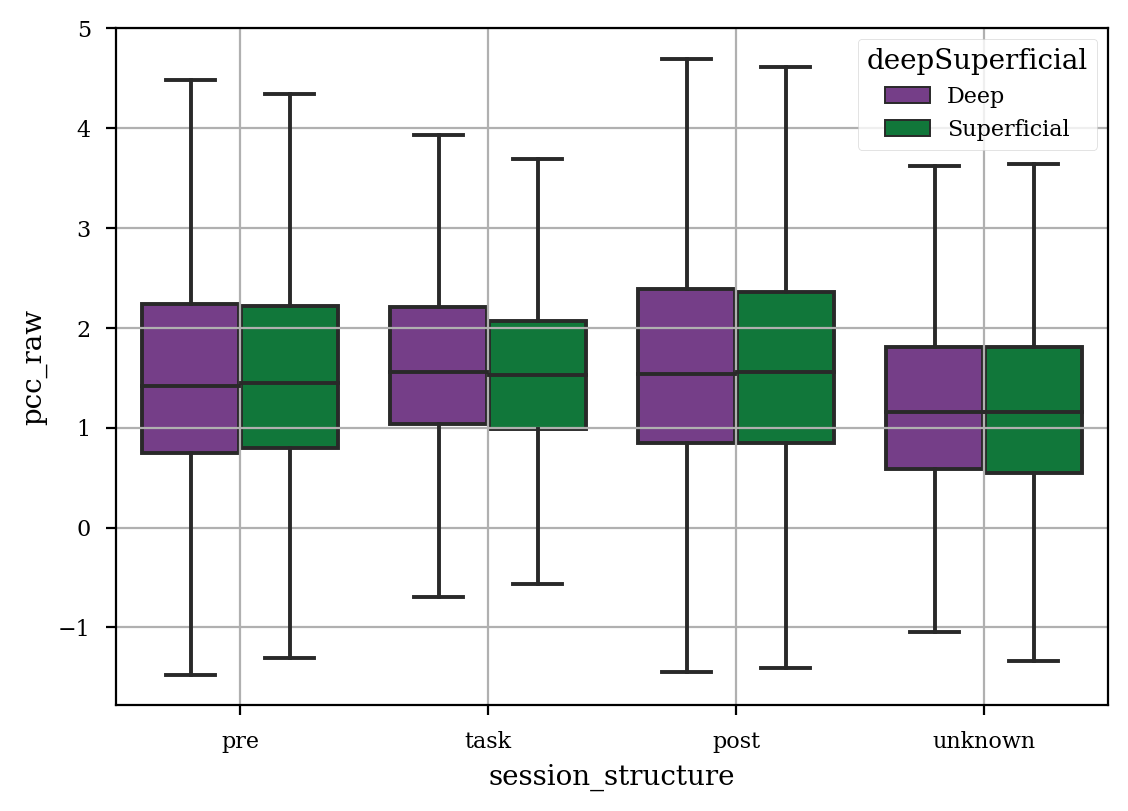

In [10]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    data=results_df.query("deepSuperficial.str.contains('Deep|Superficial')"),
    y="pcc",
    x="session_structure",
    order=["pre","task","post","unknown"],
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys()
)
plt.show()

sns.boxplot(
    data=results_df.query("deepSuperficial.str.contains('Deep|Superficial')"),
    y="pcc_raw",
    x="session_structure",
    order=["pre","task","post","unknown"],
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys()
)
plt.grid()
# sns.stripplot(
#     data=results_df.query("deepSuperficial.str.contains('Deep|Superficial')"),
#     y="pcc",
#     x="session_structure",
#     dodge=True,
#     hue="deepSuperficial",
# )

## plot pre normalized pcc

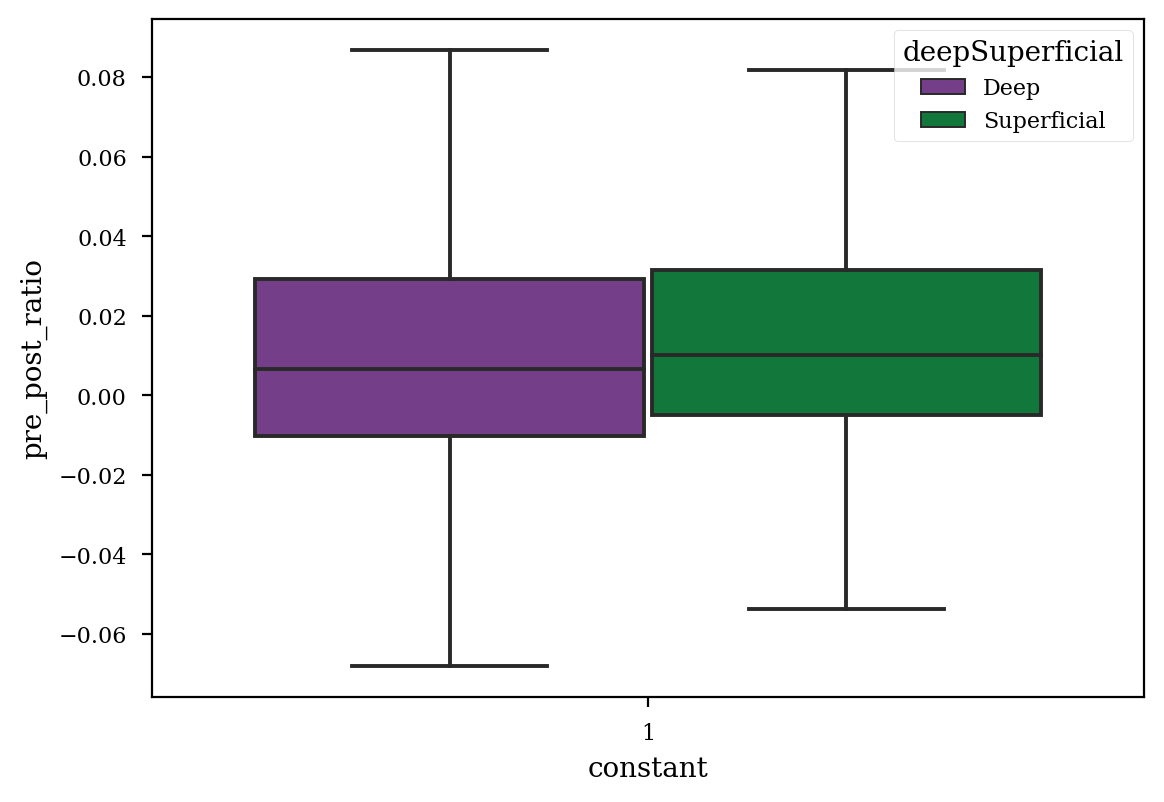

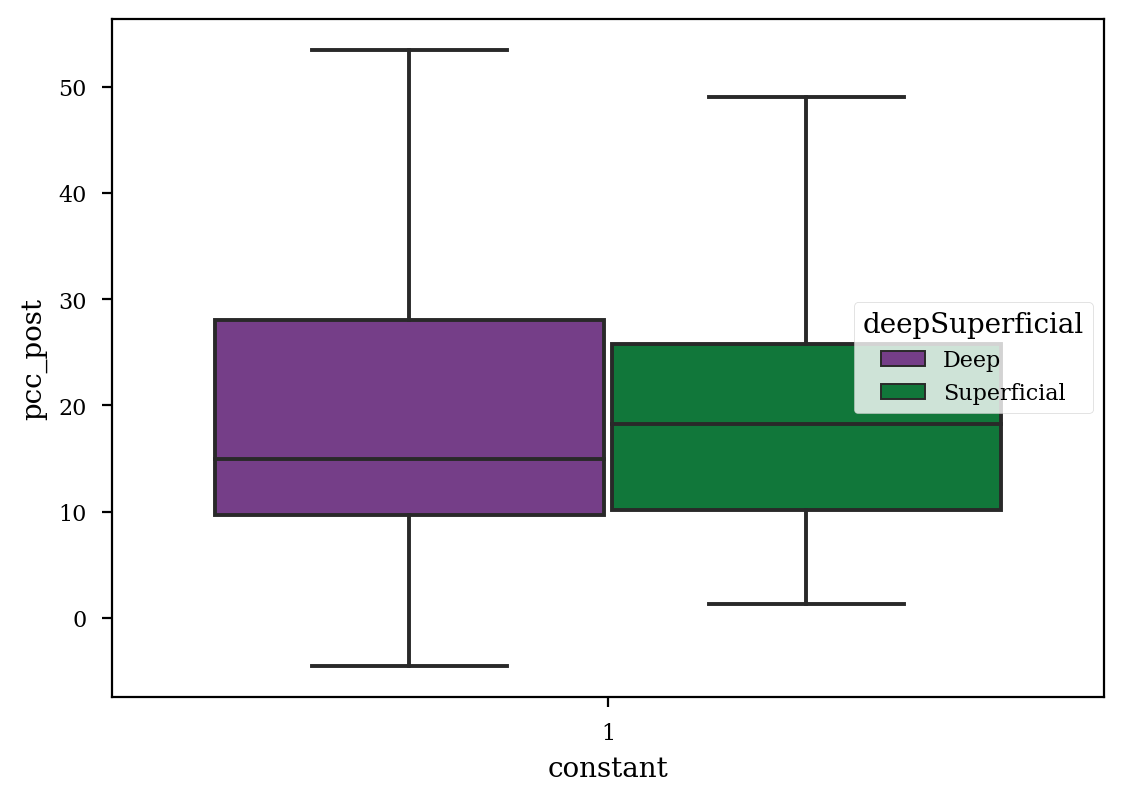

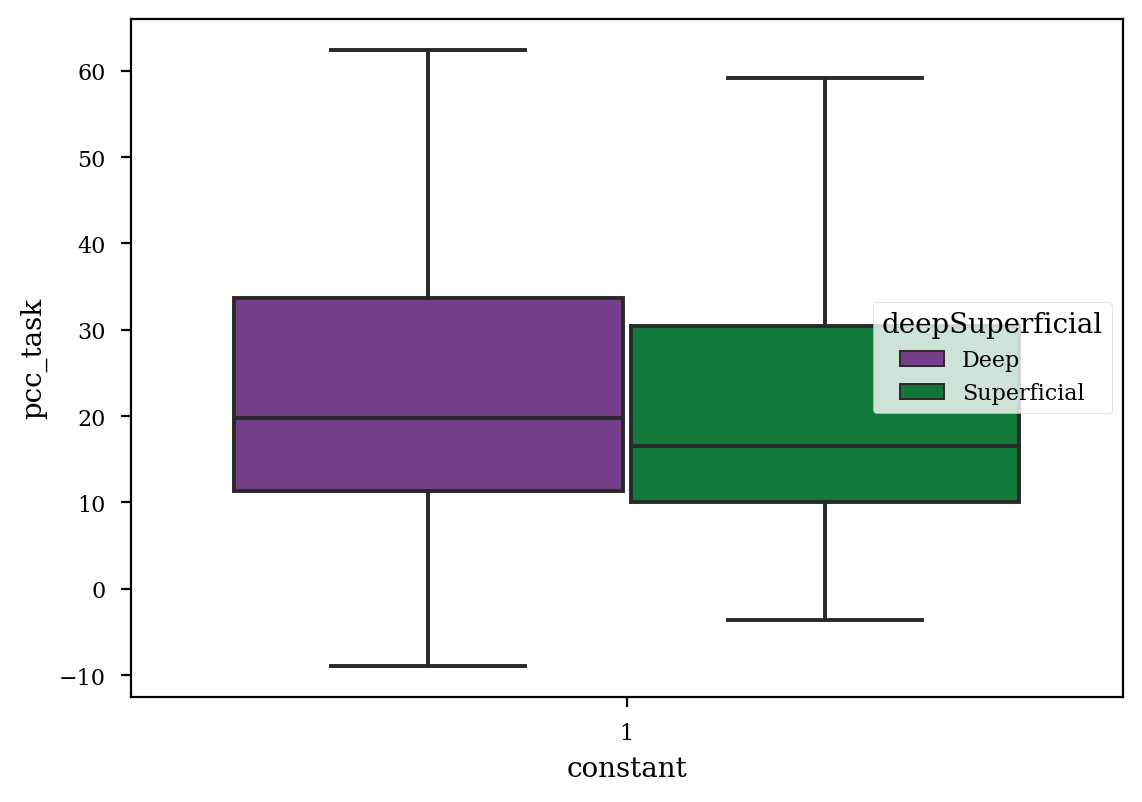

In [16]:
results_df_pivot = pd.pivot_table(
    results_df.query("session_structure != 'unknown' & not pcc.isnull()"),
    values=["pcc"],
    index=["basepath", "UID", "deepSuperficial", "n_replays", "animal_id"],
    columns=["session_structure"],
    aggfunc=np.median,
).reset_index()

results_df_pivot["pre_post_ratio"] = (
    (results_df_pivot["pcc"].post + 100) - (results_df_pivot["pcc"].pre + 100)
) / ((results_df_pivot["pcc"].post + 100) + (results_df_pivot["pcc"].pre + 100))
# results_df_pivot["pre_post_ratio"] = (results_df_pivot["pcc"].post) - (results_df_pivot["pcc"].pre)



results_df_pivot["constant"] = 1
results_df_pivot["pcc_post"] = results_df_pivot["pcc"].post.values
results_df_pivot["pcc_task"] = results_df_pivot["pcc"].task.values

sns.boxplot(
    data=results_df_pivot,
    y="pre_post_ratio",
    x="constant",
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
plt.show()

sns.boxplot(
    data=results_df_pivot,
    y="pcc_post",
    x="constant",
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
# sns.stripplot(
#     data=results_df_pivot[results_df_pivot.animal_id != "HMC2"],
#     y="pcc_post",
#     x="constant",
#     dodge=True,
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     color="k"
# )
plt.show()

sns.boxplot(
    data=results_df_pivot,
    y="pcc_task",
    x="constant",
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
plt.show()
# results_df_pivot


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_Deep vs. 1_Superficial: t-test independent samples, P_val:4.322e-01 t=-7.859e-01


(<AxesSubplot: ylabel='per cell contribution \n (pre-post ratio)'>,
 [<statannotations.Annotation.Annotation at 0x23376b97760>])

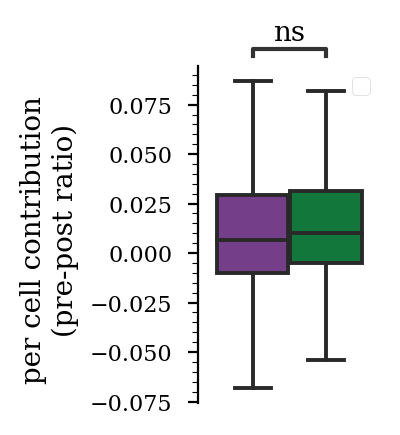

In [17]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

results_df["constant"] = 1

sns.boxplot(
    data=results_df_pivot,
    y="pre_post_ratio",
    x="constant",
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
# sns.stripplot(data=results_df_pivot,x="constant",y="pre_post_ratio",hue="deepSuperficial",color="k",dodge=True,hue_order=group_colors.keys(),s=2)


plt.ylabel("per cell contribution \n (pre-post ratio)")
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.set_xlabel("")
ax.legend("")
box_pairs = [
    ((1, "Deep"), (1, "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results_df_pivot,
    x="constant",
    y="pre_post_ratio",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

In [38]:
1.275e-01/2, 1.036e-01/2

(0.06375, 0.0518)

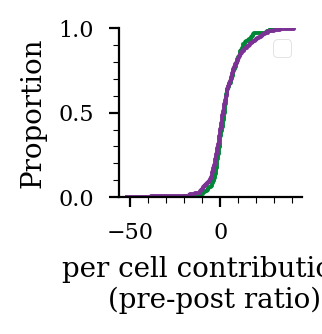

In [13]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(1.5, 1)), edgecolor=None
)
sns.ecdfplot(
    data=results_df_pivot,
    x="pre_post_ratio",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
sns.despine()

ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.xlabel("per cell contribution \n (pre-post ratio)")

ax.legend("")

### normalize post sleep start times 

In [ ]:
results_df["start_norm"] = np.nan
for basepath in results_df.basepath.unique():

    start = results_df.query("basepath == @basepath & session_structure=='post'").start.values
    if len(start) == 0:
        continue
    results_df.loc[(results_df.basepath==basepath) & (results_df.session_structure=='post'),"start_norm"] = start-start.min()

results_df.start_norm.plot()

## plot pcc 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_Deep vs. 1_Superficial: Mann-Whitney-Wilcoxon test two-sided, P_val:3.317e-05 U_stat=3.417e+05


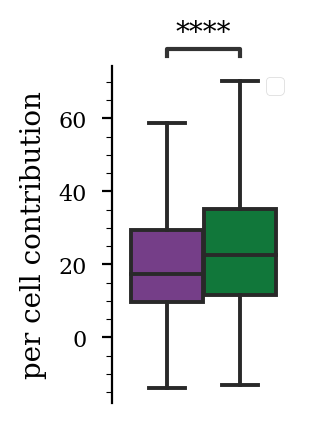

In [20]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

results_df["constant"] = 1
query = "session_structure.str.contains('task') & deepSuperficial.str.contains('Deep|Superficial')"
sns.boxplot(
    data=results_df.query(query),
    y="pcc",
    x="constant",
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
# sns.stripplot(data=results_df.query("environment=='sleep'"),y="pcc",x="deepSuperficial",color="k")


plt.ylabel("per cell contribution")
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.set_xlabel("")
ax.legend("")
box_pairs = [
    ((1, "Deep"), (1, "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results_df.query(query),
    x="constant",
    y="pcc",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

plt.savefig(
    os.path.join(fig_save_path, "per_cell_replay_contribution.svg"),
    dpi=300,
    bbox_inches="tight",
)

plt.show()

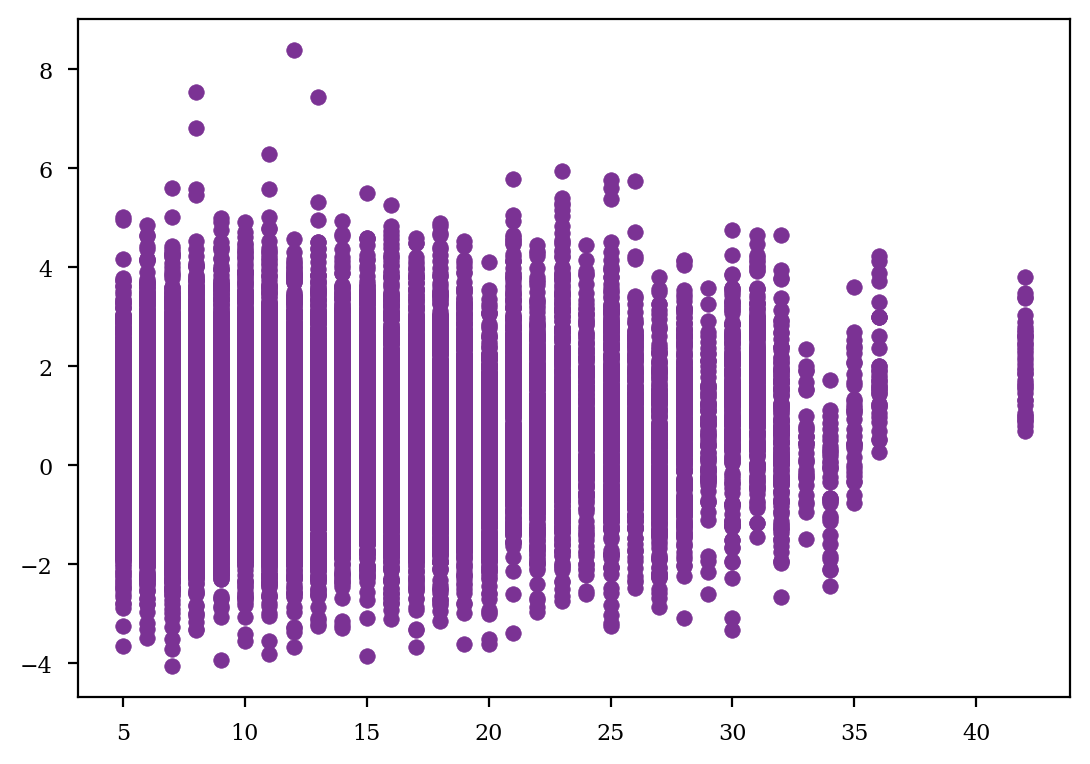

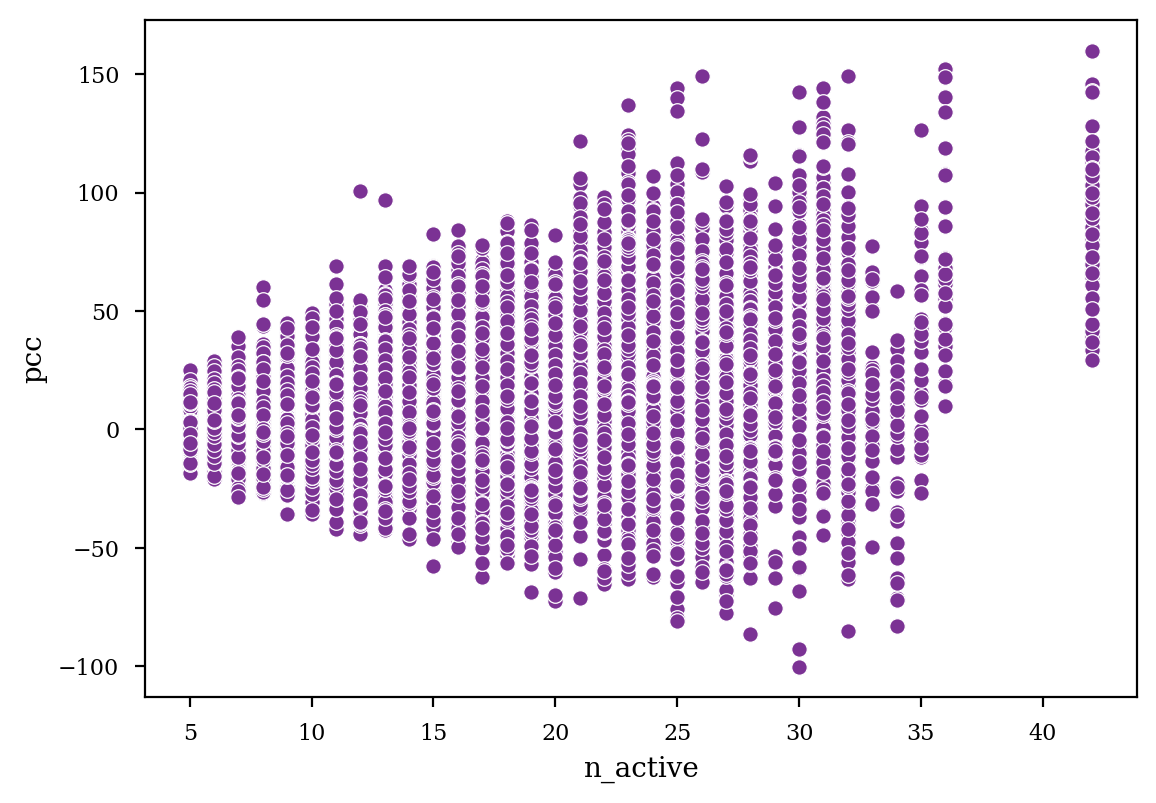

In [40]:
plt.scatter(results_df.n_active, results_df.pcc / results_df.n_active)
plt.show()
sns.scatterplot(data=results_df,x="n_active",y="pcc")
plt.show()


<AxesSubplot: xlabel='pcc', ylabel='Density'>

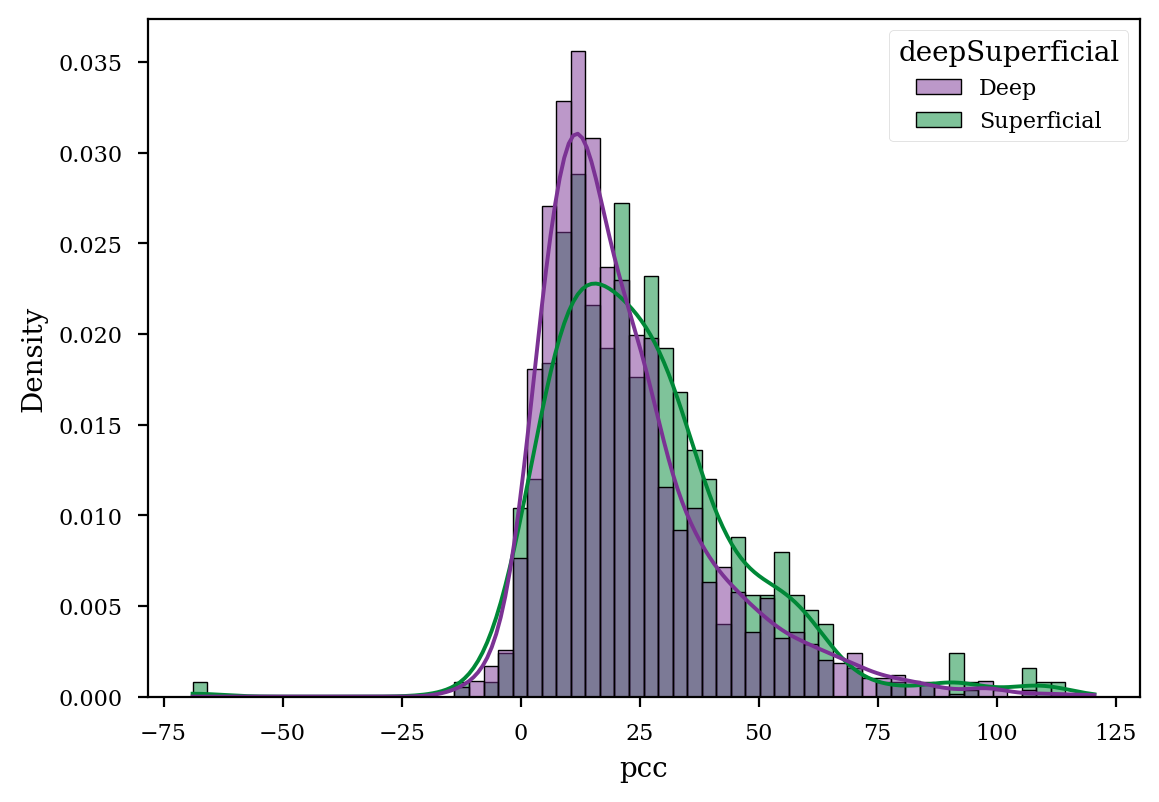

In [15]:
sns.histplot(
    results_df.query("session_structure.str.contains('task') & deepSuperficial.str.contains('Deep|Superficial')"),
    x="pcc", hue="deepSuperficial",
    hue_order=group_colors.keys(),
    # multiple="stack",
    # edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    kde=True,
    stat="density",
    common_norm=False
)

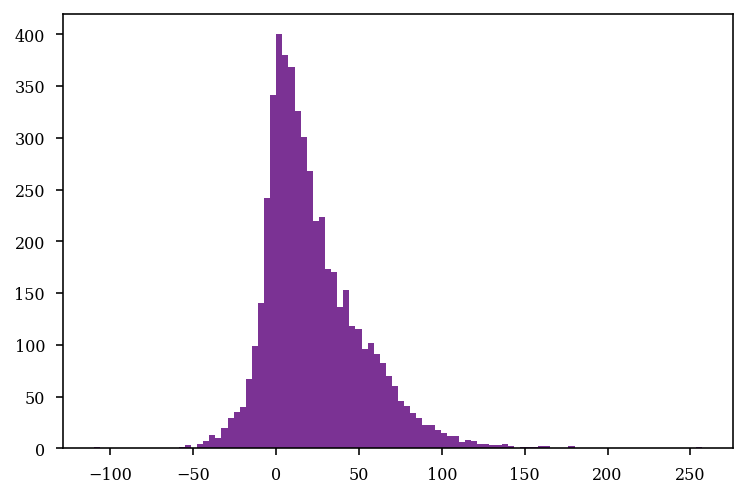

In [224]:
plt.hist(results_df.query("session_structure.str.contains('task')").pcc,100)
plt.show()

In [42]:
results_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\per_cell_contribution.csv")

## Testing below

In [8]:
# locate saved replay file and load it
save_file = os.path.join(
    replay_save_path, basepath.replace(os.sep, "_").replace(":", "_") + ".pkl"
)

with open(save_file, "rb") as f:
    results = pickle.load(f)

In [13]:
tuningcurve = results["outbound_epochs"]["tc"]
tuningcurve

<TuningCurve1D at 0x284e3997a90> with shape (93, 103)

In [40]:
import random

tuningcurve_new = copy.deepcopy(tuningcurve)

shuff_idx = random.sample(range(tuningcurve_new.ratemap.shape[1]),tuningcurve_new.ratemap.shape[0])
x = [np.roll(tc,shuff_val) for tc, shuff_val in zip(tuningcurve_new.ratemap,shuff_idx)]
x = np.array(x)

<AxesSubplot:>

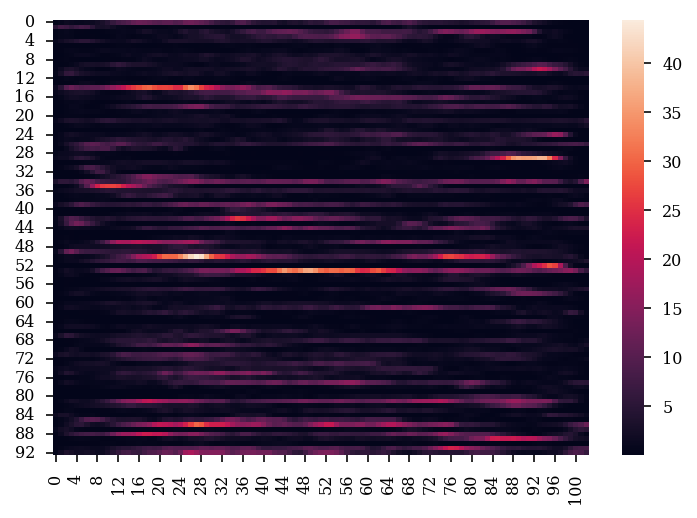

In [26]:
sns.heatmap(tuningcurve_new.ratemap)

In [49]:
n_active = [bst_.n_active for bst_ in bst]
    

In [52]:
np.array(n_active).shape

(7024,)

In [47]:
bst = results["outbound_epochs"]["bst_placecells"]
bst.n_active_per_bin.shape

(34925,)

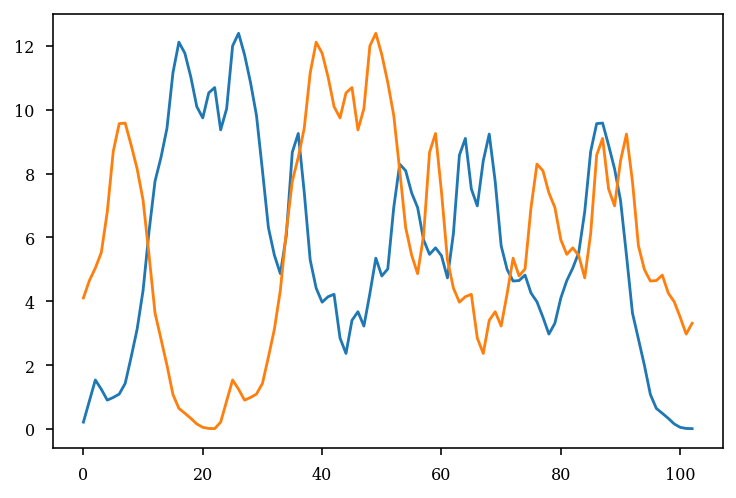

In [41]:
plt.plot(tuningcurve_new.ratemap[0,:])

plt.plot(x[0,:])

<AxesSubplot:>

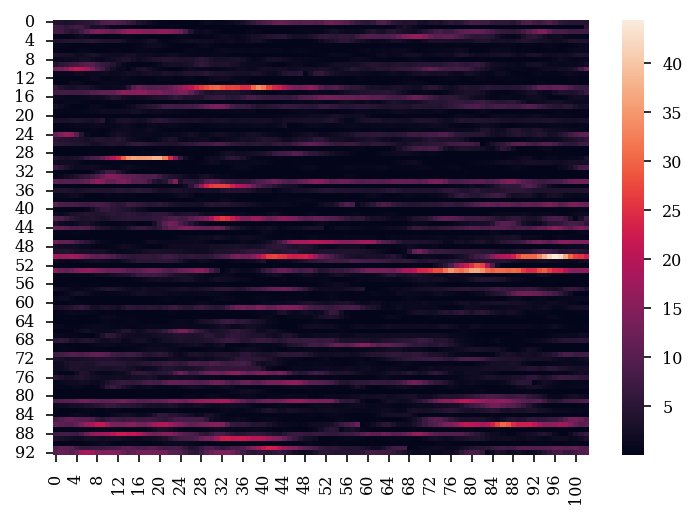

In [31]:
sns.heatmap(x)
